#660710749 อโนชา ทองด้วง

In [67]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
!pip install prophet

In [69]:
from prophet import Prophet

In [70]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [71]:
#รวมคอลัมน์ date และ time เข้าด้วยกันให้เป็นคอลัมน์ datetime เดียว
df['datetime'] = pd.to_datetime(df['date'].astype(str) + " " + df['time'].astype(str))

In [72]:
#แยกเอาเฉพาะส่วน วันที่ (date) จากคอลัมน์ datetime
df['date'] = df['datetime'].dt.date

In [73]:
#สร้างตารางสรุปยอดขายกาแฟแต่ละประเภทในแต่ละวัน
daily_sales_counts = df.groupby(['date','coffee_name']).size().reset_index(name='cups_sold')

In [74]:
print(daily_sales_counts.head(5))

         date          coffee_name  cups_sold
0  2023-03-01            Americano         19
1  2023-03-01  Americano with Milk         27
2  2023-03-01           Cappuccino         24
3  2023-03-01                Cocoa          7
4  2023-03-01              Cortado         14


In [75]:
predictions = {}

for coffee in daily_sales_counts['coffee_name'].unique():
  #กรองข้อมูลและสร้าง time series สำหรับกาแฟประเภทนั้นๆ
  ts = daily_sales_counts[daily_sales_counts['coffee_name'] == coffee][['date','cups_sold']]

In [76]:
#เปลี่ยนชื่อคอลัมน์ของ DataFrame ts ให้เป็นชื่อที่เหมาะสมสำหรับการพยากรณ์ y: ตัวแปรตามที่ต้องการการพยากรณ์
#ds: ตัวแปรเวลา
ts = ts.rename(columns={'date':'ds','cups_sold':'y'})

In [77]:
#สร้างและtrain model Prophet เพื่อการพยากรณ์ยอดขายกาแฟ
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(ts)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_cja7jyk/b68zbwur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_cja7jyk/4u4e2u3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57530', 'data', 'file=/tmp/tmp_cja7jyk/b68zbwur.json', 'init=/tmp/tmp_cja7jyk/4u4e2u3j.json', 'output', 'file=/tmp/tmp_cja7jyk/prophet_modeloq9hrbso/prophet_model-20250920175147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [78]:
#สร้าง DataFrame 60วันข้างหน้า เพื่อเตรียมไว้สำหรับการพยากรณ์
future = model.make_future_dataframe(periods=60)

In [79]:
#การพยากรณ์ด้วยโมเดล Prophet
forecast = model.predict(future)

In [80]:
#เก็บผลการพยากรณ์ของกาแฟแต่ละประเภทไว้ในpredictions
predictions[coffee] = forecast

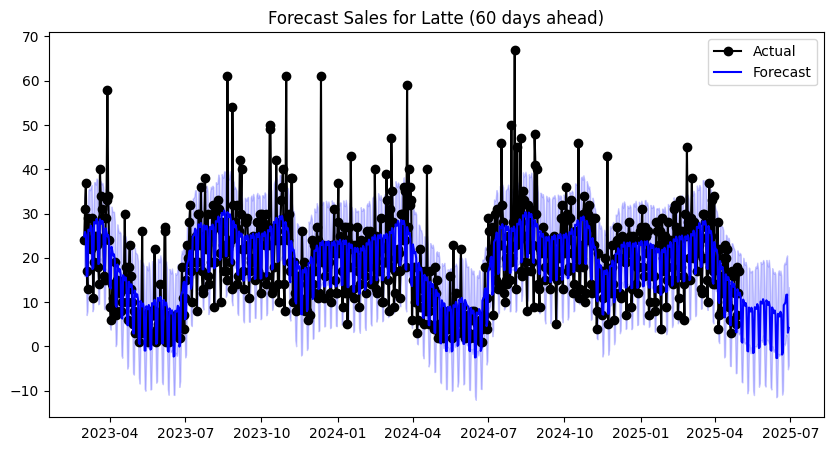

In [81]:
#กราฟแสดงการพยากรณ์ยอดขายกาแฟ
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ts['ds'], ts['y'], 'ko-', label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2)
ax.set_title(f"Forecast Sales for {coffee} (60 days ahead)")
ax.legend()

In [82]:
all_forecasts = []

for coffee, fc in predictions.items():
  #หาค่าวันที่ล่าสุดในข้อมูลและเก็บวันที่ล่าสุดไว้ในcutoff
  cutoff = daily_sales_counts['date'].max()

In [83]:
#หาแถวที่มีวันที่หลัง cutoff (อนาคต)และเอาเฉพาะแถวที่เป็น True (วันที่อนาคต)
sub = fc[fc['ds'] > pd.to_datetime(cutoff)][['ds','yhat','yhat_lower','yhat_upper']].copy()
#ระบุว่าการพยากรณ์นี้เป็นของกาแฟชนิดไหน
sub['coffee_name'] = coffee
#รวบรวมการพยากรณ์ของกาแฟทุกชนิด
all_forecasts.append(sub)

In [84]:
#รวม DataFrame ทั้งหมดให้เป็น DataFrame เดียว
future_forecast_60days = pd.concat(all_forecasts)

print(future_forecast_60days.head(30))

            ds       yhat  yhat_lower  yhat_upper coffee_name
791 2025-05-01  12.140996    3.107388   21.125659       Latte
792 2025-05-02  10.997782    2.791550   20.786749       Latte
793 2025-05-03   1.116464   -7.946039    9.213326       Latte
794 2025-05-04   0.855342   -8.130842    9.671921       Latte
795 2025-05-05  10.582619    1.957467   20.028857       Latte
796 2025-05-06   9.887765    0.889102   19.040065       Latte
797 2025-05-07   9.211931    0.638989   18.385627       Latte
798 2025-05-08   9.816345    0.927752   19.083874       Latte
799 2025-05-09   8.751323   -0.173524   17.969240       Latte
800 2025-05-10  -1.014704  -10.593920    7.558571       Latte
801 2025-05-11  -1.124145   -9.886012    7.263599       Latte
802 2025-05-12   8.789235    0.465001   17.809353       Latte
803 2025-05-13   8.311709   -0.737809   16.836774       Latte
804 2025-05-14   7.880091   -1.535330   16.720851       Latte
805 2025-05-15   8.750241   -0.168576   17.041275       Latte
806 2025